In [55]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import matplotlib
from matplotlib import colors
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from load_data import get_projections_spacing_radius
from ipywidgets import interact, widgets
import dill as pickle
import torch
import torch.nn.functional as F
from kornia.geometry.transform import rotate
from torch.nn.functional import interpolate
from scipy.optimize import minimize, curve_fit
from scipy.interpolate import CubicSpline
import pytomography
import torch.nn as nn
from pytomography.utils import pad_object, unpad_object
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import psf_net
import importlib
importlib.reload(psf_net)
from psf_net import PSFNet, get_psf_net, dual_exponential, sqrt_fit, JaggedConv2D
torch.set_default_device('cuda')
from fit import fit
import time
from fft_conv_pytorch import FFTConv1d, FFTConv2d
from cycler import cycler

C:\Users\lukep\AppData\Local\Temp\ipykernel_16092\795916267.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [56]:
ds = [10,15,20,25,30,35,40,45,50,55]
paths = [f'440kev_r{d}_s' for d in ds]
# Spacing of the theoretical kernel
Nx = 128
dx = 0.24
x_eval = y_eval = np.arange(-(Nx-1)/2, (Nx+1)/2, 1) * dx
projectionss_data = []
projectionss_analytical = []
for path in paths:
    projections_data, dr0, distance = get_projections_spacing_radius(path)
    projectionss_data.append(projections_data[1:,1:])
projectionss_data = np.array(projectionss_data)

# Part 1: Fit Parameters

In [57]:
w, iso, g_params, SA, fit_func = fit(projectionss_data, idx=0)

c:\Users\lukep\anaconda3\envs\pytorch\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\lukep\anaconda3\envs\pytorch\lib\site-packages\torch\utils\_device.py:62: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1004.)
  return func(*args, **kwargs)


Theory should now match data for all indices `idx`: (all projections in `projectionss_data`)

In [58]:
idx = 0
data = projectionss_data[idx]
theory = fit_func(w, iso, g_params, SA, idx)[0].cpu().detach()

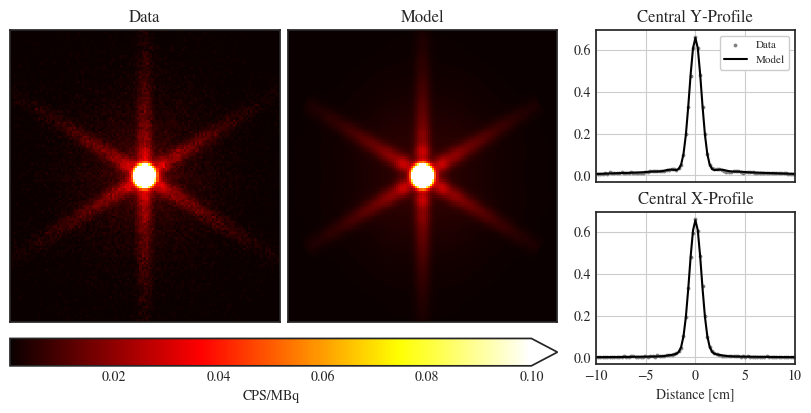

In [5]:
x = np.arange(-63, 64, 1)*dr0[0]
fig = plt.figure(constrained_layout=True, figsize=(8,4))
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=(2,0.85))
axes_l = subfig_l.subplots(nrows=1, ncols=2)
axes_l[0].pcolormesh(data.T, cmap='hot', vmax=0.1)
axes_l[0].tick_params(axis='both', which='both', length=0)
axes_l[0].set_xticklabels([])
axes_l[0].set_yticklabels([])
axes_l[0].set_title('Data')
im = axes_l[1].pcolormesh(theory.T, cmap='hot', vmax=0.1)
axes_l[1].tick_params(axis='both', which='both', length=0)
axes_l[1].set_xticklabels([])
axes_l[1].set_yticklabels([])
axes_l[1].set_title('Model')
subfig_l.colorbar(im, ax=axes_l, location='bottom', label='CPS/MBq', extend='max')

axes_r = subfig_r.subplots(nrows=2, ncols=1)
axes_r[0].scatter(x, data[64], color='grey', s=3, label='Data')
axes_r[0].plot(x, theory[64], color='k', label='Model')
axes_r[0].set_xlim(-10,10)
#axes_r[0].semilogy()
axes_r[0].set_xticklabels([])
axes_r[0].set_title('Central Y-Profile')
axes_r[0].grid()
axes_r[0].legend(facecolor='white', framealpha=1, frameon=True, loc='upper right', fontsize=8)
axes_r[1].scatter(x, data[:,64], color='grey', s=3)
axes_r[1].plot(x, theory[:,64], color='k')
axes_r[1].set_xlim(-10,10)
#axes_r[1].semilogy()
axes_r[1].set_xlabel('Distance [cm]')
axes_r[1].set_title('Central X-Profile')
axes_r[1].grid()

plt.savefig('paper_model_vs_data.png', dpi=300)

Differences:

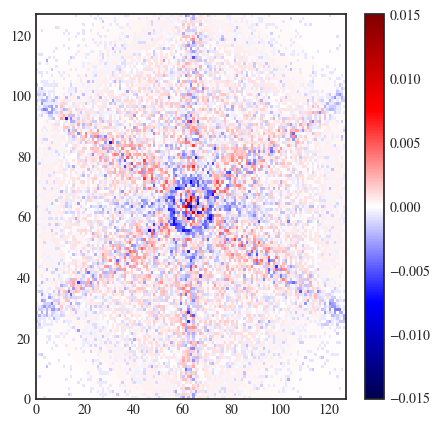

In [6]:
plt.figure(figsize=(5,5))
plt.pcolormesh(theory.T.numpy()-data.T, cmap='seismic', norm=colors.CenteredNorm())
plt.colorbar()

# Part 3: PSF Net

In [84]:
distances = np.array(ds)
psf_net = get_psf_net(np.array(ds), dr0[0], projectionss_data, w, iso, g_params, SA, Nx-1)
with open('psf_net.pkl', 'wb') as f:
    pickle.dump(psf_net, f)

In [85]:
distances = np.array(ds)
bkg_amplitude = SA[1]
bkg_sigma = SA[0]
gaus_amplitude = g_params[:,0].detach().cpu().numpy()
gaus_sigma = g_params[:,1].detach().cpu().numpy()

In [86]:
distances_theo = np.linspace(np.array(ds).min(), np.array(ds).max(), 1000)
gaus_amplitude_theo = dual_exponential(distances_theo, *psf_net.gaus_amplitude_fit)
gaus_sigma_theo = sqrt_fit(distances_theo, *psf_net.gaus_sigma_fit)
bkg_amplitude_theo = dual_exponential(distances_theo, *psf_net.bkg_amplitude_fit)
bkg_sigma_theo = sqrt_fit(distances_theo, *psf_net.bkg_sigma_fit)

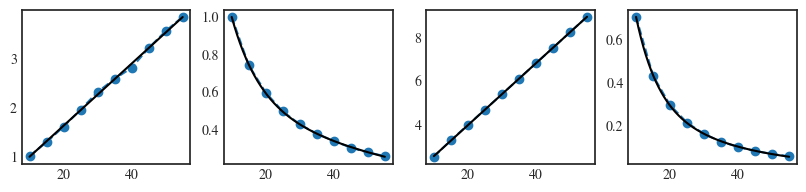

In [87]:
plt.subplots(1,4,figsize=(10,2))
plt.subplot(141)
plt.plot(distances, bkg_sigma, 'o--')
plt.plot(distances_theo, bkg_sigma_theo, color='k')
plt.subplot(142)
plt.plot(distances, bkg_amplitude, 'o--')
plt.plot(distances_theo, bkg_amplitude_theo, color='k')
plt.subplot(143)
plt.plot(distances, gaus_sigma, 'o--')
plt.plot(distances_theo, gaus_sigma_theo, color='k')
plt.subplot(144)
plt.plot(distances, gaus_amplitude, 'o--')
plt.plot(distances_theo, gaus_amplitude_theo, color='k')
plt.show()

# Testing Network

In [63]:
idx = 4
size = 127
x = torch.zeros((1,size,size,size)).to(pytomography.device)
x[:,:,63,63] = 1
pad_size = size + 2*int(np.ceil((np.sqrt(2)*size - size)/2)) 
distances_test = np.zeros(pad_size) + ds[idx]
dr = 0.24
with open('psf_net.pkl', 'rb') as f:
    psf_net = pickle.load(f)
psf_net.configure(distances_test, dr, size)
x = pad_object(x)
theory = psf_net(x, norm=False)
theory = unpad_object(theory)[0][0].cpu().numpy()
data = projectionss_data[idx]

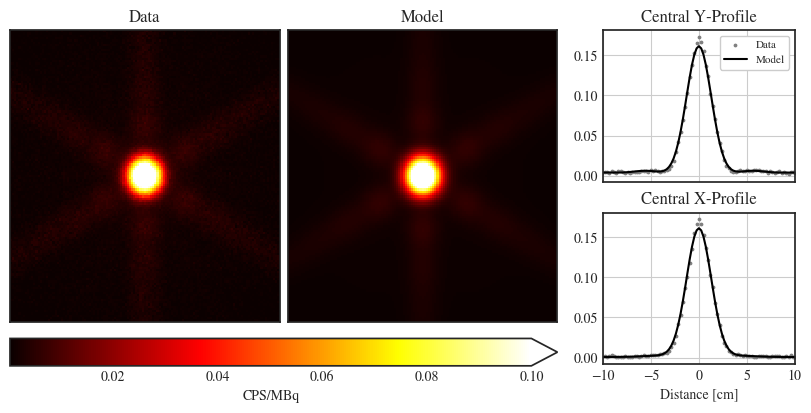

In [64]:
x = np.arange(-63, 64, 1)*dr0[0]
fig = plt.figure(constrained_layout=True, figsize=(8,4))
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=(2,0.85))
axes_l = subfig_l.subplots(nrows=1, ncols=2)
axes_l[0].pcolormesh(data.T, cmap='hot', vmax=0.1)
axes_l[0].tick_params(axis='both', which='both', length=0)
axes_l[0].set_xticklabels([])
axes_l[0].set_yticklabels([])
axes_l[0].set_title('Data')
im = axes_l[1].pcolormesh(theory.T, cmap='hot', vmax=0.1)
axes_l[1].tick_params(axis='both', which='both', length=0)
axes_l[1].set_xticklabels([])
axes_l[1].set_yticklabels([])
axes_l[1].set_title('Model')
subfig_l.colorbar(im, ax=axes_l, location='bottom', label='CPS/MBq', extend='max')

axes_r = subfig_r.subplots(nrows=2, ncols=1)
axes_r[0].scatter(x, data[64], color='grey', s=3, label='Data')
axes_r[0].plot(x, theory[64], color='k', label='Model')
axes_r[0].set_xlim(-10,10)
#axes_r[0].semilogy()
axes_r[0].set_xticklabels([])
axes_r[0].set_title('Central Y-Profile')
axes_r[0].grid()
axes_r[0].legend(facecolor='white', framealpha=1, frameon=True, loc='upper right', fontsize=8)
axes_r[1].scatter(x, data[:,64], color='grey', s=3)
axes_r[1].plot(x, theory[:,64], color='k')
axes_r[1].set_xlim(-10,10)
#axes_r[1].semilogy()
axes_r[1].set_xlabel('Distance [cm]')
axes_r[1].set_title('Central X-Profile')
axes_r[1].grid()

plt.savefig('paper_model_vs_data.png', dpi=300)

# Timing

Part 1: Determine PSF kernel for 2D PSF timing comparison:

In [2]:
def get_networks(N, dr):
    size = N + 2*int(np.ceil((np.sqrt(2)*N - N)/2)) 
    distances_test = np.linspace(60,5,size)
    with open('psf_net.pkl', 'rb') as f:
        psf_net = pickle.load(f)
    psf_net.configure(distances_test, dr)

    network_2D_FFT = JaggedConv2D(psf_net, distances_test, dr, fft=True)
    network_2D = JaggedConv2D(psf_net, distances_test, dr)

    with open('psf_net.pkl', 'rb') as f:
        network_1D = pickle.load(f)
    network_1D.configure(distances_test, dr)

    with open('psf_net.pkl', 'rb') as f:
        network_1D_FFT = pickle.load(f)
    network_1D_FFT.configure(distances_test, dr, fft=True)
    return network_1D, network_1D_FFT, network_2D, network_2D_FFT

In [3]:
N = 128
dr = 0.48
network_1D, network_1D_FFT, network_2D, network_2D_FFT = get_networks(N, dr)

Now lets time:

In [4]:
size = N + 2*int(np.ceil((np.sqrt(2)*N - N)/2)) 
data = torch.randn((1,size,size,N)).to(pytomography.device)

In [5]:
def compute_times(network, data, n_tests=50):
    times = []
    for i in range(n_tests+1):
        t0 = time.time()
        network(data)
        torch.cuda.current_stream().synchronize()
        t1 = time.time()
        # Initial time takes longer for some reason
        if i>0:
            times.append(t1-t0)
    return np.mean(times), np.std(times)

In [6]:
compute_times(network_1D, data)

(0.0309596586227417, 0.0032493583857277565)

In [7]:
def timing_experiment(Ns, drs):
    times = [[],[],[],[]]
    times_err = [[],[],[],[]]
    for N, dr in zip(Ns, drs):
        size = N + 2*int(np.ceil((np.sqrt(2)*N - N)/2)) 
        data = torch.randn((1,size,size,N)).to(pytomography.device)
        networks = get_networks(N, dr)
        for i, network in enumerate(networks):
            time, time_err = compute_times(network, data)
            times[i].append(time)
            times_err[i].append(time_err)
    return times, times_err        

In [8]:
Ns = np.array([64,96,128,196])
drs = 0.48 * 128 / Ns

In [9]:
times, times_err = timing_experiment(Ns, drs)
times = np.array(times) * 1000
times_err = np.array(times_err) * 1000

In [39]:
len(data.items())

4

In [38]:
list(data.items())[0]

('1D', array([ 15.61358929,  17.2962904 ,  30.60697079, 115.16242504]))

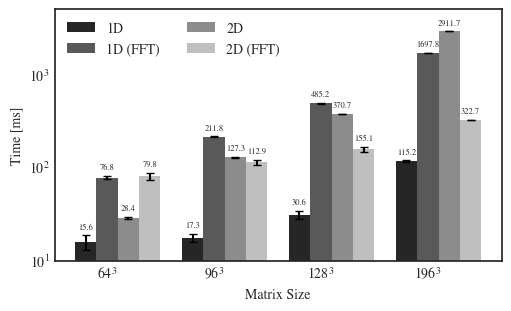

In [53]:
data = {
    '1D': times[0],
    '1D (FFT)': times[1],
    '2D': times[2],
    '2D (FFT)': times[3]
}

data_err = {
    '1D': times_err[0],
    '1D (FFT)': times_err[1],
    '2D': times_err[2],
    '2D (FFT)': times_err[3]
}

x = np.arange(len(Ns))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(5,3),layout='constrained')

for i in range(len(data.items())):
    attribute, measurement = list(data.items())[i]
    attribute, error = list(data_err.items())[i]
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=error, color=str(0.15+0.2*i), capsize=3)
    ax.bar_label(rects, padding=3, fmt='%.1f', fontsize=6)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
labels = [rf'{N}$^{3}$' for N in Ns]
ax.set_ylabel('Time [ms]')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=2)
ax.semilogy()
ax.set_xlabel('Matrix Size')
ax.set_ylim(top=5000)
plt.savefig('timing.png', dpi=300)

In [335]:
ax.bar_label?

Signature:
ax.bar_label(
    container,
    labels=None,
    *,
    fmt='%g',
    label_type='edge',
    padding=0,
    **kwargs,
)
Docstring:
Label a bar plot.

Adds labels to bars in the given `.BarContainer`.
You may need to adjust the axis limits to fit the labels.

Parameters
----------
container : `.BarContainer`
    Container with all the bars and optionally errorbars, likely
    returned from `.bar` or `.barh`.

labels : array-like, optional
    A list of label texts, that should be displayed. If not given, the
    label texts will be the data values formatted with *fmt*.

fmt : str or callable, default: '%g'
    An unnamed %-style or {}-style format string for the label or a
    function to call with the value as the first argument.
    When *fmt* is a string and can be interpreted in both formats,
    %-style takes precedence over {}-style.

    .. versionadded:: 3.7
       Support for {}-style format string and callables.

label_type : {'edge', 'center'}, default: 'edge'
   

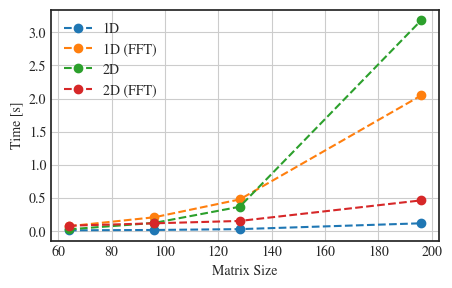

In [328]:
labels=['1D', '1D (FFT)', '2D', '2D (FFT)']
plt.figure(figsize=(5,3))
[plt.plot(Ns, times[i], 'o--', label=labels[i]) for i in range(4)]
plt.grid()
plt.legend()
plt.ylabel('Time [s]')
plt.xlabel('Matrix Size')
plt.show()

In [325]:
times[0][2]

0.031438074111938476

In [323]:
times[0][2] * 32 * 2 * 100 / 60

3.3533945719401044